# MIDI encoding analysis

This document contains a complete description step by step of the process and ideas behind the proposed encodings, it might be long.

## TLDR:

The encoding instead of being a huge one-hot vector (dimension 4708) it can be separated in several inputs each of them a one-hot vector of lower dimensionality and a time encoding given by a sum of sinusoids with different period. 

The source code is provided to automatically do the encoding as a python package with numpy.

Current encoding based in the Magenta project has the following properties:
 - Time is detached as a separate TIME_SHIFT event
 - code is one hot of all the 

## Introduction

This current analysis tries to find another alternative encoding to try in conjunction with the previous one. 

The idea of the current analysis is to discuss the following points:
 - Try to find a code that takes less space
 - Argue that alternative time-coding could be worth trying
 
The current encoding separates a TIME_SHIFT event as a separate event, in my opinion the time of an event is an intrinsic property of it, so separating it might make more difficult for the network to learn what the time means. 

The other issue is that similar structures (in music as well as in other kind of languages) might repeat at different time scales, the fact that the time event is treated as one separate event with it's own duration (actually 100 different types of TIME_SHIFT event) might make it harder to the network to detect patterns. This added to the high number of input features (4708) makes me think that the training time and number of samples needed for the training might be big.

In [1]:
# current input one-hot vector dimension
16*128*2+32*16+100

4708

In this study I propose another way of encoding that I would like to try reducing the number of features between 1 and 2 orders of magnitude and providing a Fourier series approximation inspired time and velocity approximation.

I know that is not a traditional encoding, but I think might be worth trying (specially as I don't have so many computational resources)

## Basic Idea Description

The basic idea is that a feature vector will be composed of several different features (7) encoded in different ways

From a midi file extract:

Event = [instrument, octave, note(s), action (on|off), velocity, time]

### Codes:

* instrument: (one|multi?) hot encoding: 16 instruments, many instruments can start or finish at the same time
* octave: (one|multi?) hot encoding: 11 octaves, many octaves can have an event at the same time
* note(s): (one|multi?) hot encoding: 12 notes per octave, many notes can start or finish at the same time
* action (on|off): one hot
* velocity: either a sampled (maybe 32 as the current approach) one-hot encoding, or a fourier inspired approach
* time: Fourier inspired approach to encoding

### Encoding Problems & Questions

As there might be more than 1 note, octave or instrument event at the same this could be dealt as:
1. doing an actual one-hot encoding and separating all the events, but writing the same event time -> can this confuse the network??
2. doing a multi-hot encoding and trying to find out a way ouf of this during the decoding stage (something like auto-correlation or a sort of dynamic-routing ? ) This would also mix the signals of the velocity of each note, which is problematic for the purpose of the exercise.

### Features candidates for One-hot Encoding

As MIDI events are independent (each note on|off event of a single instrument is a different event) and for the purpose of this encoding proposal the solution would be to do actual one-hot encoding and separate all the events. A single event will correspond to a single instrument and note event with the corresponding velocity and time encoding.
 

In [2]:
# computation of the number of octaves needed for the encoding
import numpy as np
np.ceil(128/12.)

11.0

In [3]:
# dimensionality analysis -> basic (one)-hot encoding
16 + 11 + 12 + 2

41

The basic coding of the event will contain a minimum of 41 dimensions to which must be added the encoding of the velocity and time encoding

### Velocity encoding

Both solutions are presented here, One-Hot Encoding and Fourier Inspired Encoding.

#### One-Hot encoding of Velocity

In this case the same number of velocities will be used as in the current approach, this means that the velocity vector will have a dimension of 32

#### Sinusoidal (Fourier Inspired) Encoding of Velocity

The resolution that is looked at is to be able to differentiate at least 32 different velocities.

As a description later on time encoding analysis will show, we can deal with a resolution of 256 velocities with $ 256 = 2^8 $ sinusoidals which would take the dimensionality of the input to $ 41 + 8 = 49 $

For a resolution of 32 velocities we need only $ 32 = 2^5 $ for a the dimensionality of the input to $ 41 + 5 = 46 $


In [4]:
2**8, 2**5

(256, 32)

## Time encoding 


### Why not linear encoding?

Let's do a simple linear function, this can not hold as it diverges

Let's imaging an encoding where the time is cutted in 3 different parts:
* milliseconds
* seconds
* minutes

the functions will be linear in a range, but will have undefined elements at the borders, the derivatives are undefined there and the NNs are shown that they do not behave nice with these kind of functions

Then we can think of a continuous function, sinusoidal ones are really good for this, well studied and implemented in every standard library.



### Time resolution Analysis

Now let's think for a moment from the point of view of listening to  music (instead of time passing) for this we'd like a time resolution: 

* maximum (desired) 10 milliseconds.
* minimum about 10 minutes ... ? let's take 10 minutes for the sake of this example (could be more or less depending on the needed domain)

_Note_: There are studies on real-time [latency issue](https://dl.acm.org/citation.cfm?id=1085892) but is not of our concern here.

For a perfect reconstruction the sampling frequency to discretize a function is given by the [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem):

    If a function x(t) contains no frequencies higher than B hertz, 
    it is completely determined by giving its ordinates at a series 
    of points spaced 1/(2B) seconds apart.
    
Which means that for a *perfect* reconstruction for a given sample rate $fs$ is guaranteed for a *Bandlimit* $B < fs/2$

Let's imagine that we want to approximate the time for a minimum and maximum time interval, we could use sum of sinusoids to approximate it. 

In our case $B = 100Hz $ for the maximum frequency (100 times 10 ms for 1 sec), hence the sampling rate would be *5ms*, taking in account that also there will be reconstruction errors and some other issues we could argue that $ fs<5ms $ let's say $ 4ms $ to be sure 

And for the case of the 10 minutes one, this gives us $ 10*60 = 600 s $ so $ 1/600 ~ 0.00167Hz =>  fs < 0.000833Hz $

As a reference the human hearing resolution is about $ 20KHz $ and the CD sampling is $ 44.1KHz $ 

In [5]:
f = (1./600)
fs = f/2
f,fs

(0.0016666666666666668, 0.0008333333333333334)

### Time encoding details


First let's put here some reference Formulas

*Euler's Formula* 
\begin{equation}
 e^{ix} = cos(x) + i\sin(x)
\end{equation}

\begin{equation}
 cos(x) = \frac{e^{ix} + e^{-ix} } {2}
\end{equation}

\begin{equation}
 sin(x) = \frac{e^{ix} - e^{-ix} } {2 i }
\end{equation}


*Fourier Series* 

\begin{equation}
f(x) = \sum_{n=-\infty}^\infty(c_n(f) e^{i2\pi {n/T} x} )
\end{equation}
where
\begin{equation}
c_n(f) = \frac{1}{T} \int_{-T/2}^{T/2} ( f(t) e^{-i2\pi {n/T} x} ) 
\end{equation}

In our case there is no need to go so far as using the Fourier Series but this gives an inspiration on how to encode the values. 
Also we don't want (or even need):
 - the complete series $ [-\infty,\infty] $ but enough values that allows us to reconstruct well enough our function
 - to know the * Fourier Coefficients* $ c_n $ we don't need to compute the integral but we can estimate their values (done later)

We could use either the *Complex Domain* values or go for the *Discrete Cosine Transform* but we'll do something simpler that is choosing sinusoidals

Let's come back to time and think how we can encode the time, which is a linear function that just grows.

For this analysis we constrain the time to be only a segment between $ 0s $ and a max value $ Ms $ in seconds

To be able to recreate the original function we would need a series of functions that can represent elements that go from the maximum to the minimum resolution.

Let the first sinusoidal represent the values up to the period $ T = 5ms = 0.005s $ and the last one $ Ms $ 

Now let's work directly in milliseconds and forget about the unit, which for the purpose of the experiment does not affect the result as long as we can reconstruct the input correctly.

We can encode any value between $ [0,5]ms $ , for the next we can duplicate the period $ T $ and we'll get the next resolution level. Advancing like this we need at least $ n $ values such as $ 2^n >= M $ and for the minimum resolution we need at most $ n $ values such as $ 2^n < 5 $

This can be quickly achieved with a bit shifting trick:


In [6]:
def get_upper_pow2(M):
    i = 1
    n = 0
    while (i <= M):
        i = i << 1
        n+=1
    return n,i

def get_lower_pow2(M):
    i = 1
    n = -1
    while (i <= M):
        i = i << 1
        n+=1
    return n,i

In [7]:
for m in range (1,11): # iterating to show the vector dimension needed for each minute increment resolution
    M = m * 60 * 1000 # 10 minutes, 60 seconds per minute 1000 ms -> putting all into
    n,i = get_upper_pow2(M)
    print( m, n, i)

1 16 65536
2 17 131072
3 18 262144
4 18 262144
5 19 524288
6 19 524288
7 19 524288
8 19 524288
9 20 1048576
10 20 1048576


In [8]:
# and the smallest resolution:
get_lower_pow2(5)

(2, 8)

Which means that we can encode 10 minutes worth of music with a $ 20 - 2 = 18 $ dimensional vector, $ 36 $ if we count a complex-value vector. 


For a total of $ 46 + 36 = 82 $ dimensions instead of $ 4708 $


In [9]:
np.exp(2j*np.pi)

(1-2.4492935982947064e-16j)

In [10]:
class WaveEncoder():
    
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val
        self.n_low = self.get_lower_pow2(min_val)
        self.n_high =  self.get_upper_pow2(max_val)
        self.n = self.n_high - self.n_low 
        
    
    def encode(self, x):
        vec = [] # np.empty_like(x)
        for i in range(self.n_low, self.n_high):
            T = 2**i
            # # vec.append(np.exp(2*np.pi * x / T )) ##
            val = np.stack( (np.cos(x / T), np.sin(x / T) ))
            vec.append(val)
#             print(val.shape)
#         print(len(vec))
        ret = np.stack(vec)
#         print(ret.shape)
        return ret
    
    def decode(self, vec):
        x = 0
        scale_factor = []
        for i in range(self.n_low, self.n_high):
            T = 2**i
            scale_factor.append((T/self.n, T/self.n))
        scale_factor = np.array(scale_factor)
        tx = vec * scale_factor[:,:,None]
        tx = np.sum(tx, axis=0)
        x += np.diff(tx, axis=0)
        return x
    
    def get_upper_pow2(self, M):
        i = 1
        n = 0
        while (i <= M):
            i = i << 1
            n+=1
        return n

    def get_lower_pow2(self, m):
        i = 1
        n = -1
        while (i <= m):
            i = i << 1
            n+=1
        return n

In [11]:
we = WaveEncoder(5,10000)

In [12]:
l = np.linspace(0,10000,10000)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

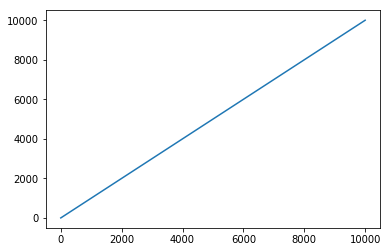

In [14]:
plt.plot(l)

In [15]:
el  = we.encode(l)

In [16]:
el.shape

(12, 2, 10000)

In [17]:
dl = we.decode(el)

In [18]:
dl.shape

(1, 10000)

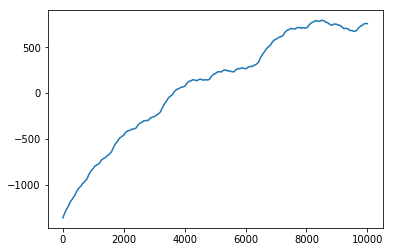

In [19]:
plt.plot(dl.T)

In [20]:
a = np.array([[1, 2, 3], [7,8,9]])
b = np.array([[2, 3, 4], [70,80,90]])

np.stack((a, b)).shape

(2, 2, 3)

In [21]:
v = []
for i in range(1,11):
    w = []
    for j in range(11,17):
        w.append([i, i * j])
    v.append(w)

In [22]:
v

[[[1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16]],
 [[2, 22], [2, 24], [2, 26], [2, 28], [2, 30], [2, 32]],
 [[3, 33], [3, 36], [3, 39], [3, 42], [3, 45], [3, 48]],
 [[4, 44], [4, 48], [4, 52], [4, 56], [4, 60], [4, 64]],
 [[5, 55], [5, 60], [5, 65], [5, 70], [5, 75], [5, 80]],
 [[6, 66], [6, 72], [6, 78], [6, 84], [6, 90], [6, 96]],
 [[7, 77], [7, 84], [7, 91], [7, 98], [7, 105], [7, 112]],
 [[8, 88], [8, 96], [8, 104], [8, 112], [8, 120], [8, 128]],
 [[9, 99], [9, 108], [9, 117], [9, 126], [9, 135], [9, 144]],
 [[10, 110], [10, 120], [10, 130], [10, 140], [10, 150], [10, 160]]]

In [23]:
np.stack(v).shape

(10, 6, 2)